# Create OD volumes Using Generation and Distribution Steps

In [11]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel

import pandas as pd

if manual:
    %matplotlib inline

## Read Model

In [12]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/aon_pathfinder'.format(scen=argv['scenario']))

lines: 100%|██████████| 31/31 [00:00<00:00, 37.91it/s]                  


# Generation
- Production = Population
- Attraction = Jobs

In [13]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# Distribution
- Car owners (30% of population) distribution is proportional to car time
- PT captives (70% of population) distribution is proportional to PT time

## Car Owners

In [14]:
motor_rate = 0.3

In [15]:
car = sm.copy()
car.zones['emission'] *= motor_rate

# Impedence matrice = car time
imp_matrix = car.car_los[['origin', 'destination', 'time']].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)
car.step_distribution(deterrence_matrix = imp_matrix)

# PT Captives

In [16]:
pt = sm.copy()
pt.zones['emission'] *= (1 - motor_rate)

# Impedence matrice = PT time
imp_matrix = pt.pt_los[['origin', 'destination', 'gtime']].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)
pt.step_distribution(deterrence_matrix = imp_matrix)

## Merge volume matrices

In [17]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})
sm.volumes.head(5)

,origin,destination,car_owner,pt_captive
0,zone_0,zone_0,0.005188,0.008204
1,zone_0,zone_1,0.175681,0.378281
2,zone_0,zone_2,0.136994,0.316779
3,zone_0,zone_3,0.185262,0.408741
4,zone_0,zone_4,0.180202,0.393932


# Export

In [18]:
sm.to_zippedpickles(
    argv['training_folder'] + '/model/{scen}/distribution'.format(scen=argv['scenario']), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

volumes: 100%|██████████| 32/32 [00:00<00:00, 1721.58it/s]


# Monitoring

In [19]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Car Owner Distribution')

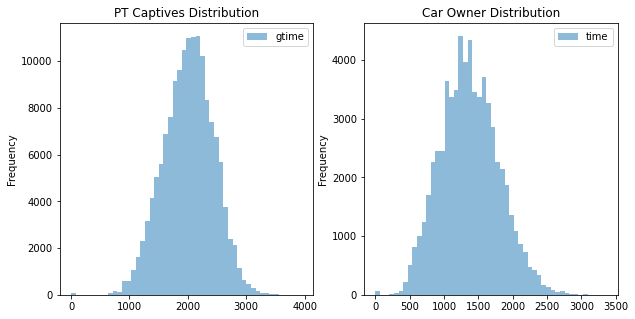

In [20]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('PT Captives Distribution')
plot = od[['time']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('Car Owner Distribution')

# END